## Imports and Data Intro <a id = "2"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import random
pd.set_option('mode.chained_assignment', None)

In [2]:
df_sp = pd.read_csv("../../data/spicata_clean_500.csv")
df_sp.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_106532\4074931185.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sp = pd.read_csv("../../data/spicata_clean_500.csv")


,Unnamed: 0,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,...,species_guess,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff
0,0,156253,1990-09-01 20:20:16,1990-09-01,1990-09-02 00:20:16+00:00,Eastern Time (US & Canada),317,2012-12-03 02:52:30+00:00,research,http://www.inaturalist.org/observations/156253,...,Cururu Toad,Rhinella diptycha,Cururu Toad,Animalia,Rhinella,Rhinella diptycha,0,0,-1.000000e-03,-0.001000
1,1,99704839,Fri May 20 1994 09:37:00 GMT-0400 (EDT),1994-05-20,1994-05-20 13:37:00+00:00,Eastern Time (US & Canada),317,2021-10-29 13:45:37+00:00,research,https://www.inaturalist.org/observations/99704839,...,Brown-headed Cowbird,Molothrus ater,Brown-headed Cowbird,Animalia,Molothrus,Molothrus ater,0,0,1.953437e+06,7492.228775
2,2,99705133,Fri May 20 1994 09:37:00 GMT-0400 (EDT),1994-05-20,1994-05-20 13:37:00+00:00,Eastern Time (US & Canada),317,2021-10-29 13:49:59+00:00,research,https://www.inaturalist.org/observations/99705133,...,Northern Cardinal,Cardinalis cardinalis,Northern Cardinal,Animalia,Cardinalis,Cardinalis cardinalis,0,0,0.000000e+00,0.000000
3,3,160735,Thu May 20 1994 15:27:35 GMT-0400 (EDT),1994-05-20,1994-05-20 19:27:35+00:00,Eastern Time (US & Canada),317,2012-12-11 20:23:37+00:00,research,http://www.inaturalist.org/observations/160735,...,Brown-headed Cowbird,Molothrus ater,Brown-headed Cowbird,Animalia,Molothrus,Molothrus ater,0,0,3.505833e+02,0.472500
4,4,36335283,Wed Jul 28 1999 08:24:34 GMT-0400 (EDT),1999-07-28,1999-07-28 12:24:34+00:00,Eastern Time (US & Canada),317,2019-12-04 01:50:03+00:00,research,https://www.inaturalist.org/observations/36335283,...,American Red Squirrel,Tamiasciurus hudsonicus,American Red Squirrel,Animalia,Tamiasciurus,Tamiasciurus hudsonicus,0,0,2.728377e+06,56.747939


In [3]:
# drop repeat index column
df_sp.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
# convert time objects to UTC datetimes
df_sp["time_observed_at"] = pd.to_datetime(df_sp["time_observed_at"], utc = True)
df_sp["created_at"] = pd.to_datetime(df_sp["created_at"], utc = True)

In [5]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050151 entries, 0 to 1050150
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype              
---  ------                            --------------    -----              
 0   id                                1050151 non-null  int64              
 1   observed_on_string                1050151 non-null  object             
 2   observed_on                       1050151 non-null  object             
 3   time_observed_at                  1050151 non-null  datetime64[ns, UTC]
 4   time_zone                         1050151 non-null  object             
 5   user_id                           1050151 non-null  int64              
 6   created_at                        1050151 non-null  datetime64[ns, UTC]
 7   quality_grade                     1050151 non-null  object             
 8   url                               1050151 non-null  object             
 9   image_url                         1

## Feature Engineering Datetimes <a id = "3"></a>

Datetimes don't work for models and many graphs. There are boundless ways to engineer the datetime for EDA and later modeling. For now, I am choosing two options:
1) Continuous: "time passed since" -- I am choosing the earliest time that occurs in the dataset (minimum value of "time_observed_at", setting it to zero and measuring the other times in minutes since that earliest time
2) Discrete values: Breaking the "time_observed_at" and "created_at" dates into a column for each of its discrete integer parts: Year, Month, Day, Hour (leaving out minutes, especially because I already have a column engineered from the original EDA that measures each observation for a user in minutes since their last observation)

### Continuous time columns -- "minutes since"

In [6]:
# Creates a column ("obs_time_conv_(minutes)") that measures all observation times in minutes 
#that have passed since first observation of dataset

min_time = df_sp["time_observed_at"].min() # finds first time_observed for dataset
time_since = df_sp["time_observed_at"] - min_time #calcs diff between time_observed for row and first time
time_obs_conv = round((time_since.dt.total_seconds()) / 60 , 2) # converts diff to minutes
df_sp.loc[:, "obs_time_conv_(minutes)"] = time_obs_conv # stores values in a new column

df_sp.sample(3) #sanity check


,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,scientific_name,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff,obs_time_conv_(minutes)
775359,145637222,2023-01-01 10:57:23-06:00,2023-01-01,2023-01-01 16:57:23+00:00,America/St_Lucia,1174034,2023-01-02 03:44:57+00:00,needs_id,https://www.inaturalist.org/observations/14563...,https://inaturalist-open-data.s3.amazonaws.com...,...,Piperaceae,pepper plant family,Plantae,not stated,not stated,0,0,0.300000,0.119669,41228279.38
912780,117250414,2022-05-12 13:24:49-05:00,2022-05-12,2022-05-12 18:24:49+00:00,Central Time (US & Canada),2590765,2022-05-16 02:03:35+00:00,needs_id,https://www.inaturalist.org/observations/11725...,https://inaturalist-open-data.s3.amazonaws.com...,...,Thalictrum dioicum,early meadow-rue,Plantae,Thalictrum,Thalictrum dioicum,0,0,59.166667,4.083362,40891406.82
148412,14181937,2018-07-04 08:49:30,2018-07-04,2018-07-04 13:49:30+00:00,Central Time (US & Canada),35203,2018-07-08 22:49:50+00:00,research,https://www.inaturalist.org/observations/14181937,https://inaturalist-open-data.s3.amazonaws.com...,...,Danaus plexippus,Monarch,Animalia,Danaus,Danaus plexippus,0,0,0.000000,0.052804,38863611.50


In [7]:
# Creates a column ("created_at_conv_(minutes)") that measures all "created_at" times in minutes 
# that have passed since first observation of dataset

# uses "min_time" from above--all still measured from first observation time, otherwise same code 
time_since = df_sp["created_at"] - min_time 
created_at_conv = round((time_since.dt.total_seconds()) / 60 , 2) 
df_sp.loc[:, "created_at_conv_(minutes)"] = created_at_conv
df_sp.sample(3)

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,common_name,taxon_kingdom_name,taxon_genus_name,taxon_species_name,geoprivacy_obscured,taxon_geoprivacy_obscured,minute_diff,km_diff,obs_time_conv_(minutes),created_at_conv_(minutes)
136362,169659982,2023/06/26 9:15 AM,2023-06-26,2023-06-26 13:15:00+00:00,Eastern Time (US & Canada),27450,2023-06-26 21:39:24+00:00,research,https://www.inaturalist.org/observations/16965...,https://static.inaturalist.org/photos/29416531...,...,red maple,Plantae,Acer,Acer rubrum,0,0,1.000000,0.000000,41481497.00,41482001.40
438850,25649303,2019/05/23 5:20 PM CDT,2019-05-23,2019-05-23 22:20:00+00:00,Central Time (US & Canada),395895,2019-05-24 00:41:57+00:00,research,https://www.inaturalist.org/observations/25649303,https://inaturalist-open-data.s3.amazonaws.com...,...,American Robin,Animalia,Turdus,Turdus migratorius,0,0,0.000000,0.000000,39329242.00,39329383.95
268590,173061997,2023-07-14 21:24:25-07:00,2023-07-14,2023-07-15 04:24:25+00:00,Pacific Time (US & Canada),150454,2023-07-15 18:24:30+00:00,research,https://www.inaturalist.org/observations/17306...,https://inaturalist-open-data.s3.amazonaws.com...,...,Large Yellow Underwing,Animalia,Noctua,Noctua pronuba,0,0,96.133333,0.016315,41508326.42,41509166.50


### Discrete time columns -- Year, Month, Day and Hour

In [8]:
# creating a separate dataframe for these values and then concatenating them
# using this method because it ran the fastest and didn't throw warnings 
# whereas other ways of storing these directly back into df_sp did

# creating empty dataframe to store converted columns
discrete_time_df = pd.DataFrame()

# creating discrete columns from observation times
discrete_time_df['obs_year'] = df_sp['time_observed_at'].dt.year
discrete_time_df['obs_month'] = df_sp['time_observed_at'].dt.month
discrete_time_df['obs_day'] = df_sp['time_observed_at'].dt.day
discrete_time_df['obs_hour'] = df_sp['time_observed_at'].dt.hour

# creating discrete columns from inat posting times
discrete_time_df['created_year'] = df_sp['created_at'].dt.year
discrete_time_df['created_month'] = df_sp['created_at'].dt.month
discrete_time_df['created_day'] = df_sp['created_at'].dt.day
discrete_time_df['created_hour'] = df_sp['created_at'].dt.hour

In [9]:
 df_sp = pd.concat([df_sp, discrete_time_df], axis = 1)

In [10]:
df_sp.sample(3)

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,obs_time_conv_(minutes),created_at_conv_(minutes),obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour
559041,142292406,2022/11/17 10:30 AM,2022-11-17,2022-11-17 16:30:00+00:00,Central Time (US & Canada),521220,2022-11-18 14:54:01+00:00,needs_id,https://www.inaturalist.org/observations/14229...,https://inaturalist-open-data.s3.amazonaws.com...,...,41163452.00,41164796.02,2022,11,17,16,2022,11,18,14
574861,127890590,2022-06-28 17:42:03-04:00,2022-06-28,2022-06-28 21:42:03+00:00,Eastern Time (US & Canada),552204,2022-07-25 19:49:38+00:00,needs_id,https://www.inaturalist.org/observations/12789...,https://static.inaturalist.org/photos/21717135...,...,40959284.05,40998051.63,2022,6,28,21,2022,7,25,19
477691,100449650,2021/11/06 3:08 PM CDT,2021-11-06,2021-11-06 20:08:00+00:00,Central Time (US & Canada),395895,2021-11-07 00:45:31+00:00,research,https://www.inaturalist.org/observations/10044...,https://inaturalist-open-data.s3.amazonaws.com...,...,40622230.00,40622507.52,2021,11,6,20,2021,11,7,0


How heavy are some of these users going to be on my DBSCAN model? 

In [11]:
# What is the distribution of the number of rows for each user id?
df_sp["user_id"].value_counts().describe()

count      300.000000
mean      3500.503333
std       7996.269869
min          3.000000
25%        222.500000
50%        691.000000
75%       3110.750000
max      85077.000000
Name: user_id, dtype: float64

I've run a few examples through. 3000 rows takes a little time to get through the optimization code, 6000 rows takes a LOT but 85077 rows might actually break my kernal. For the sake of time, I am going to just choose the 75th percentile and below which still leaves 225 users. 

In [12]:
#Create a list of the users in the lower 75% percentile

# stores the third quartile
third_quartile = df_sp["user_id"].value_counts().describe()[6]

#creates empty list
bottom_75_users = []

# iterates through the list of all users
for id in df_sp["user_id"].unique():
    #if the count for the user is less than or equal to Q3, it gets added to the list
    if df_sp[df_sp['user_id'] == id]["id"].count() <= third_quartile:
        bottom_75_users.append(id)

#sanity check
len(bottom_75_users)

225

In [13]:
df_sp_smaller = df_sp[df_sp["user_id"].isin(bottom_75_users)]
df_sp_smaller.shape

# DANG! I did not expect SO MUCH OF THE DATA to be in the top 25% of users

(154566, 39)

In [14]:
# Sanity check about those other users
df_sp[~df_sp["user_id"].isin(bottom_75_users)].shape[0]/df_sp.shape[0]

#YUP. The top 25% of the users make up 85% of this data set *wide eye emojii* 

0.8528154522540092

Worth noting that because of this really big difference in user behavior, I might miss out on some important insights if I only apply my model to the smaller cases. I am moving forward with that idea but if I have time (now or after bootcamp), it is worth exploring if there is something different about clusters for that top 25% of users.

In [15]:
# work on code to make "no clusters" work
df_sp[df_sp["user_id"] == 3062686]

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,obs_time_conv_(minutes),created_at_conv_(minutes),obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour
978558,47353194,Mon May 25 2020 18:33:44 GMT-0400 (EDT),2020-05-25,2020-05-25 22:33:44+00:00,Eastern Time (US & Canada),3062686,2020-05-26 01:21:38+00:00,needs_id,https://www.inaturalist.org/observations/47353194,https://static.inaturalist.org/photos/75101246...,...,39859175.73,39859343.63,2020,5,25,22,2020,5,26,1
978559,47353380,Mon May 25 2020 18:38:05 GMT-0400 (EDT),2020-05-25,2020-05-25 22:38:05+00:00,Eastern Time (US & Canada),3062686,2020-05-26 01:23:24+00:00,research,https://www.inaturalist.org/observations/47353380,https://static.inaturalist.org/photos/75101527...,...,39859180.08,39859345.40,2020,5,25,22,2020,5,26,1
978560,47354148,Mon May 25 2020 18:50:29 GMT-0400 (EDT),2020-05-25,2020-05-25 22:50:29+00:00,Eastern Time (US & Canada),3062686,2020-05-26 01:30:57+00:00,research,https://www.inaturalist.org/observations/47354148,https://static.inaturalist.org/photos/75103017...,...,39859192.48,39859352.95,2020,5,25,22,2020,5,26,1
978561,47354815,Mon May 25 2020 19:08:43 GMT-0400 (EDT),2020-05-25,2020-05-25 23:08:43+00:00,Eastern Time (US & Canada),3062686,2020-05-26 01:38:19+00:00,research,https://www.inaturalist.org/observations/47354815,https://static.inaturalist.org/photos/75105593...,...,39859210.72,39859360.32,2020,5,25,23,2020,5,26,1
978562,47355465,Mon May 25 2020 19:10:40 GMT-0400 (EDT),2020-05-25,2020-05-25 23:10:40+00:00,Eastern Time (US & Canada),3062686,2020-05-26 01:45:14+00:00,research,https://www.inaturalist.org/observations/47355465,https://static.inaturalist.org/photos/75105680...,...,39859212.67,39859367.23,2020,5,25,23,2020,5,26,1
978563,49966756,Wed Jun 17 2020 14:07:26 GMT-0400 (EDT),2020-06-17,2020-06-17 18:07:26+00:00,Eastern Time (US & Canada),3062686,2020-06-17 18:09:08+00:00,research,https://www.inaturalist.org/observations/49966756,https://static.inaturalist.org/photos/79333491...,...,39892029.43,39892031.13,2020,6,17,18,2020,6,17,18
978564,50793325,Wed Jun 24 2020 11:52:12 GMT-0400 (EDT),2020-06-24,2020-06-24 15:52:12+00:00,Eastern Time (US & Canada),3062686,2020-06-24 17:34:49+00:00,research,https://www.inaturalist.org/observations/50793325,https://static.inaturalist.org/photos/80805885...,...,39901974.20,39902076.82,2020,6,24,15,2020,6,24,17
978565,50874431,Wed Jun 24 2020 13:33:01 GMT-0400 (EDT),2020-06-24,2020-06-24 17:33:01+00:00,Eastern Time (US & Canada),3062686,2020-06-25 12:10:00+00:00,research,https://www.inaturalist.org/observations/50874431,https://static.inaturalist.org/photos/80805716...,...,39902075.02,39903192.00,2020,6,24,17,2020,6,25,12
978566,51458009,Tue Jun 30 2020 07:29:37 GMT-0400 (EDT),2020-06-30,2020-06-30 11:29:37+00:00,Eastern Time (US & Canada),3062686,2020-06-30 11:31:47+00:00,research,https://www.inaturalist.org/observations/51458009,https://static.inaturalist.org/photos/81759253...,...,39910351.62,39910353.78,2020,6,30,11,2020,6,30,11
978567,56863615,Tue Aug 18 2020 14:18:06 GMT-0400 (EDT),2020-08-18,2020-08-18 18:18:06+00:00,Eastern Time (US & Canada),3062686,2020-08-18 18:47:58+00:00,research,https://www.inaturalist.org/observations/56863615,https://static.inaturalist.org/photos/90650200...,...,39981320.10,39981349.97,2020,8,18,18,2020,8,18,18


In [16]:
# slice of larger data related to this user
random_user = 3062686
rand_user_df = df_sp[df_sp["user_id"] == random_user]
rand_user_df.reset_index(inplace = True, drop = True)
rand_user_df.sample(3)

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,obs_time_conv_(minutes),created_at_conv_(minutes),obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour
23,91000693,Fri Aug 13 2021 10:31:11 GMT-0400 (EDT),2021-08-13,2021-08-13 14:31:11+00:00,Eastern Time (US & Canada),3062686,2021-08-13 14:33:16+00:00,research,https://www.inaturalist.org/observations/91000693,https://static.inaturalist.org/photos/15045942...,...,40499493.18,40499495.27,2021,8,13,14,2021,8,13,14
22,90552019,Mon Aug 09 2021 10:47:53 GMT-0400 (EDT),2021-08-09,2021-08-09 14:47:53+00:00,Eastern Time (US & Canada),3062686,2021-08-09 16:32:41+00:00,research,https://www.inaturalist.org/observations/90552019,https://static.inaturalist.org/photos/14966830...,...,40493749.88,40493854.68,2021,8,9,14,2021,8,9,16
15,81561615,Fri Jun 04 2021 10:25:36 GMT-0400 (EDT),2021-06-04,2021-06-04 14:25:36+00:00,Eastern Time (US & Canada),3062686,2021-06-04 14:27:15+00:00,research,https://www.inaturalist.org/observations/81561615,https://static.inaturalist.org/photos/13656821...,...,40398687.60,40398689.25,2021,6,4,14,2021,6,4,14


In [17]:
rand_user_df["time_zone"].value_counts()

Eastern Time (US & Canada)    41
Pacific Time (US & Canada)     3
Central Time (US & Canada)     1
Name: time_zone, dtype: int64

For ease and due to time constraint, I chose to leave the timestamp in UTC. This will make my non ML model a little less reliable because I am grouping by day according to "UTC" rather than local time. However my goal here is not to develop the most reliable non ML model but rather use it as an approximation of clustering so I choose this shortcut because all I need is an approximation. UTC still allows DBSCAN to cluster by relative time which is what we're looking for. This means that interpretation of user behavior around "time of day" is not reliable but it isn't the focus of this project. If I were to find that the DBSCAN models were performing poorly, an option would be to re-engineer the times into local times to see if that is helpful.

## Non ML Model for External Validation <a id = "6"></a>

### What can I find by just grouping by date?

We can assume nearly all users will NOT be doing overnight hikes especially with observations posted to iNaturalist so we can capture nearly 100% of hikes if we "cluster" by dates and choose a threshold for the minimum number of samples required on that date to be considered a "hike". This method will also indiscriminately include things that are not clustered in time and space, so this non ML model can act like a baseline for external validation. Can the DBSCAN models find these clusters but improve on the finds: cutting out noise that isn't part of a hike, identifying two hikes in one day, and/or throwing out data that isn't taken in a hike-like pattern?

In [18]:
# Use the date of time_observated_at to group and count rows
# Look at top 20 values when sorted lowest to highest
potential_hikes = rand_user_df["time_observed_at"].dt.strftime('%D').value_counts().sort_values().tail(20)
potential_hikes

08/30/20    1
04/24/21    1
05/15/22    1
05/06/22    1
06/02/21    1
06/17/20    1
05/19/23    1
05/28/23    1
06/24/21    1
06/24/20    2
08/13/21    2
08/09/21    2
07/03/22    2
09/17/22    2
09/11/21    3
09/04/22    3
08/18/20    3
02/11/23    3
08/08/21    4
05/25/20    5
Name: time_observed_at, dtype: int64

In [19]:
# making an array of the dates with at least as many observations as the min_samples specified

min_samples = 10 # using same terminology as DBSCAN
top_dates = potential_hikes[potential_hikes.values >= min_samples].index
top_dates

Index([], dtype='object')

In [20]:
# creating dictionary that will assign an integer to each cluster

artificial_cluster = {}
i = 0
for day in top_dates:
    artificial_cluster[day] = i
    i += 1
artificial_cluster
    

{}

In [21]:
# Adding a cluster column to the dataframe

for i in range(rand_user_df.shape[0]):
    # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
    if rand_user_df.loc[i, "time_observed_at"].strftime('%D') in top_dates:
        rand_user_df.loc[i, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[i, "time_observed_at"].strftime('%D')]
    # otherwise, the new column will be assigned a -1 (the way DBSCAN does for noise)
    else:
        rand_user_df.loc[i, "Artif_Cluster"] = -1
rand_user_df.sample(3)

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,created_at,quality_grade,url,image_url,...,created_at_conv_(minutes),obs_year,obs_month,obs_day,obs_hour,created_year,created_month,created_day,created_hour,Artif_Cluster
23,91000693,Fri Aug 13 2021 10:31:11 GMT-0400 (EDT),2021-08-13,2021-08-13 14:31:11+00:00,Eastern Time (US & Canada),3062686,2021-08-13 14:33:16+00:00,research,https://www.inaturalist.org/observations/91000693,https://static.inaturalist.org/photos/15045942...,...,40499495.27,2021,8,13,14,2021,8,13,14,-1.0
14,81415673,Wed Jun 02 2021 15:07:00 GMT-0400 (EDT),2021-06-02,2021-06-02 19:07:00+00:00,Eastern Time (US & Canada),3062686,2021-06-03 11:09:55+00:00,research,https://www.inaturalist.org/observations/81415673,https://static.inaturalist.org/photos/13354014...,...,40397051.92,2021,6,2,19,2021,6,3,11,-1.0
20,90454498,Sun Aug 08 2021 17:30:44 GMT-0400 (EDT),2021-08-08,2021-08-08 21:30:44+00:00,Eastern Time (US & Canada),3062686,2021-08-08 21:33:12+00:00,research,https://www.inaturalist.org/observations/90454498,https://static.inaturalist.org/photos/14950001...,...,40492715.20,2021,8,8,21,2021,8,8,21,-1.0


In [22]:
# making this column an integer because for some reason its a float
rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

In [23]:
# sanity check
(rand_user_df["Artif_Cluster"] != -1).sum()

0

In [24]:
potential_hikes[potential_hikes.values >= min_samples].sum()

0

In [25]:
def cluster_overview(col, df = rand_user_df, x = "time_observed_at", y_1 = "latitude", y_2 = "longitude"):
    
    '''
    Takes in the column name for where the cluster labels are assigned 
    and returns a graph of the data with latitude and longitude over time.
    Includes options for changing the dataframe or the columns for analysis. 
    
    Arguments:
    col = Column in dataframe for desired color coding (will only color 10 largest groupings) --should be assigned as integers
    df = default is rand_user_df but user can specify a different dataframe
    x = default is the "time_observed_at" columns but user can identify a different independent variable
    y_1 = default is the "latitude" column but user can identify a different dependent variable
    y_2 = default is the "longitude" column but user can identify a 2nd dependent variable to be plotted on same graph
    (or rewrite the column for y_1 to only see that)
    
    Returns: 
    Scatterplot with elongated width of dependent variable(s) against independent variable
    color coded for the top 10 most populous classifications specified by "col" 
    '''
    
    # defining a set of colors to use for graphing clusters --can add more here if desired
    class_colors = ['#A9A9A9', '#FF000D', '#BC13FE', '#FF7124', '#41FDFE', '#FF028D', '#21FC0D', '#FFF700', '#0165FC', '#000000']
    
    plt.figure(figsize=(19, 4))

    labels = np.sort(df[col].unique()) 
    # I've only specified 10 colors for labels, so if there are more, 
    # I'm visualizing the top 10 largest (by count) clusters 
    if len(labels) > 10:
        labels = np.sort(df[col].value_counts().head(10).index)

    # makes a separate scatter for each cluster label, which allows color and label to be assigned separately
    c = 0 # for assigning a color
    for i in labels: 
        subset = df[df[col] == i]
        # Create a scatter plot for each subset with the corresponding color and label--one for y_1 and one for y_2
        plt.scatter(subset[x], subset[y_1], c=class_colors[c], label= i, alpha = 0.7)
        plt.scatter(subset[x], subset[y_2], c=class_colors[c], alpha = 0.7)
        plt.xlabel(x)
        plt.ylabel(f'{y_1} \nand {y_2}')
        plt.title(f'Clusters for {col}')
        c += 1


    plt.legend()
    plt.show()

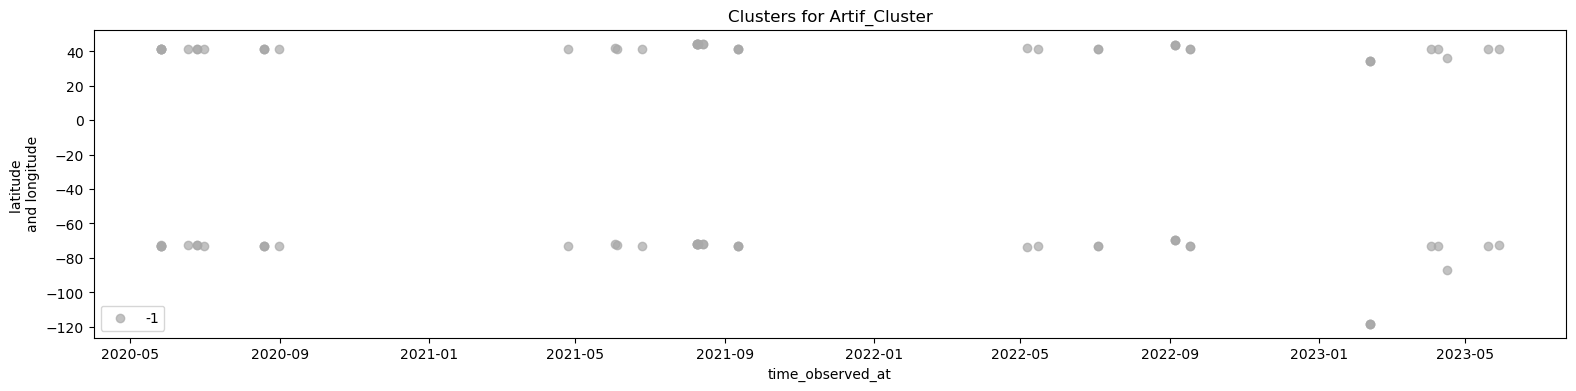

In [26]:
cluster_overview("Artif_Cluster")

Looks like all of the users spurts of several observations in a day happened in 2019. You can see the corresponding lat/lon happening for each cluster.

The 3D plots are generally difficult for me to analyze, read and navigate. I would have an easier time reading 2D graphs that show one view of the "cluster" over space and one view of one of the space columns with respect to time. I'll want to perform this visualization repeatedly so I created a function.

In [27]:
def cluster_views(col, df = rand_user_df, x = "latitude", y = "longitude", z = "obs_time_conv_(minutes)"):
    '''
    Takes in the column name for where the cluster labels are assigned 
    and returns a two graphs for each cluster -- one over space and one with respect to space/time.
    
    Arguments:
    col = Column in dataframe for desired clustering--should be assigned as integers
    df = default is rand_user_df but user can specify a different dataframe
    x = default is the "latitude" columns but user can identify a different independent variable
    y = default is the "longitude" column but user can identify a different dependent variable (for both graphs)
    z = default is the "obs_time_conv_(minutes)" column but user can identify a 2nd independent variable for the 2nd graph
    
    Returns: 
    Scatterplots of x and y beside a scatterplot of z and y for each cluster group specified in "col" 
    (excluding a -1 cluster--this code can be commented out if noise is desired for visualization)
    The scatterplots are scaled so that the x axis, y axis and z axis all span the same relative amount of time/space
    for best comparison of clustering. 
    '''  
    
    # idenifying uniquely named clusters in order
    labels = np.sort(df[col].unique()) 

    
    # find the biggest diff of lat, lon and time for all clusters
    # to make all windows for graphs cover the same approximate area
    lat_diff = 0
    lon_diff = 0
    time_diff = 0
    for i in labels:
        cluster = df[df[col] == i]
        x_diff = cluster[x].max() - cluster[x].min() # largest difference in the cluster
        if x_diff > lat_diff:
            lat_diff = x_diff # replaces largest overall diff if cluster diff is bigger
        y_diff = cluster[y].max() - cluster[y].min()
        if y_diff > lon_diff:
            lon_diff = y_diff
        z_diff = cluster[z].max() - cluster[z].min()
        if z_diff > time_diff:
            time_diff = z_diff

    # graph all clusters
    # num of rows:
    r = len(labels)
    #set up axes for subplots: 2 per cluster
    plt.subplots(r, 2, figsize=(8, 25))
    # space between subplots (code from geeks for geeks)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)

    sub_num = 1 # initial subplot will be 1
    for i in labels:           
        # identify the data for the specific cluster
        cluster = df[df[col] == i]
        # create the scale relative to differences calculated above
        min_x = cluster[x].min() - 0.001
        max_x = cluster[x].min() + lat_diff + 0.001
        min_y = cluster[y].min() - 0.001
        max_y = cluster[y].min() + lon_diff + 0.001
        min_z = cluster[z].min() - 10
        max_z = cluster[z].min() + time_diff + 10

        # create scatters for x and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[x], cluster[y], c = '#74ac00')
        plt.title(f'Cluster {i} has {cluster.shape[0]} points')
        plt.xlabel(x)
        plt.xlim(min_x, max_x) 
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1 # move the count along for what subplot we are on
        
        # create scatters for z and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[z], cluster[y], c = '#337AB7')
        plt.xlabel("time since obs1")
        plt.xlim(min_z, max_z)
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1  # move the count along for what subplot we are on

    plt.show()

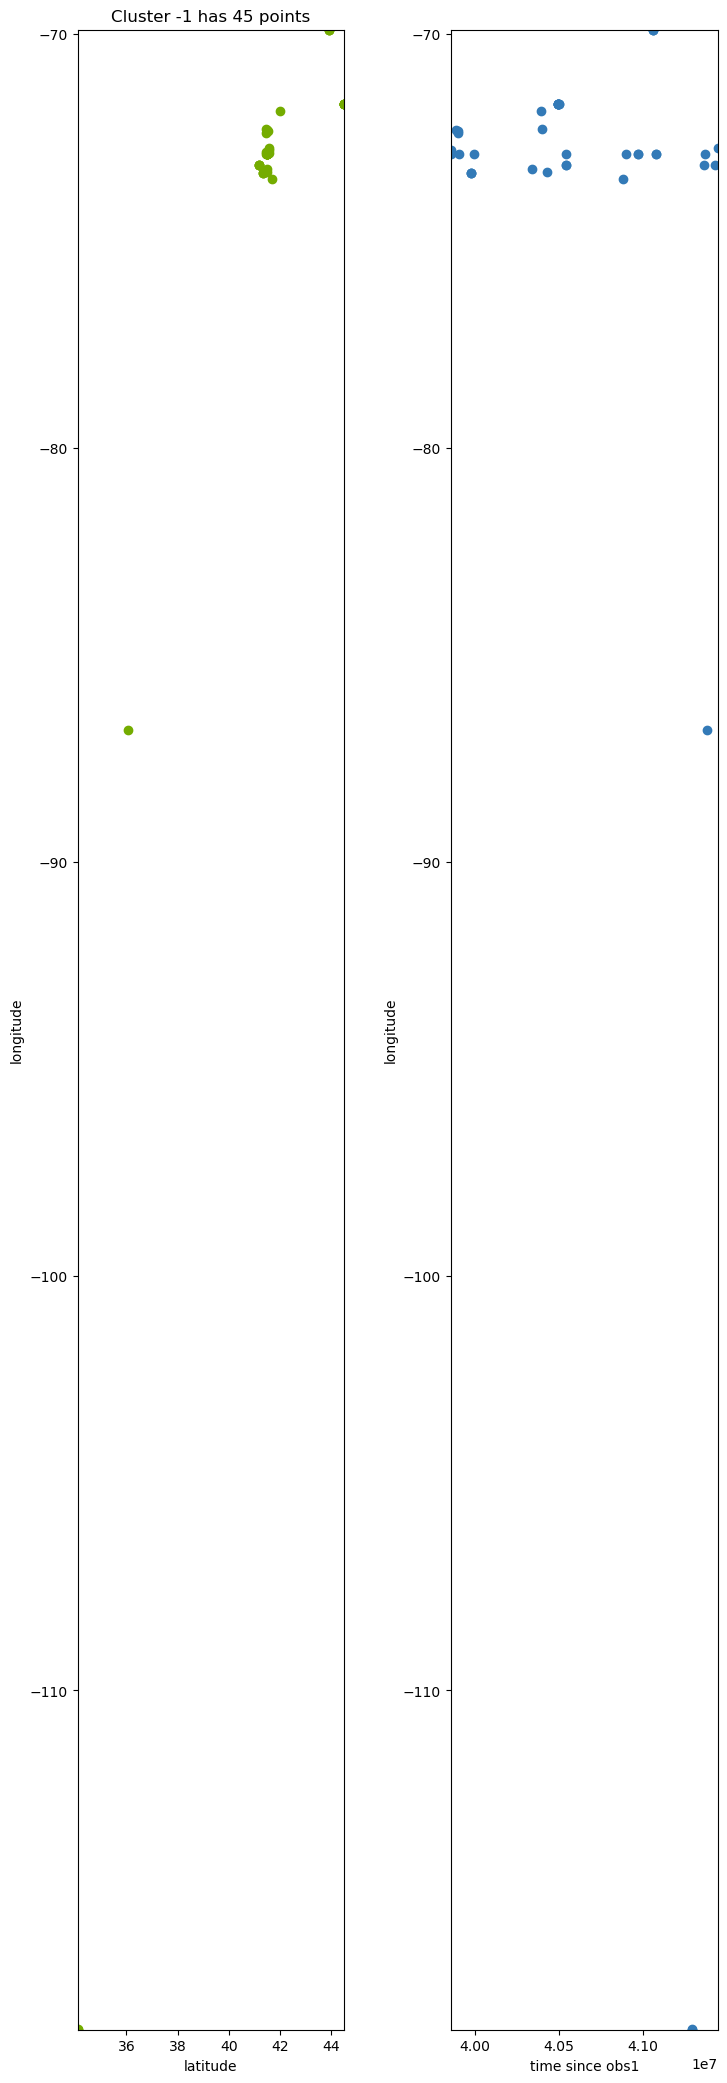

In [28]:
cluster_views("Artif_Cluster")

Some of these look like hikes (cluster 3) while others do not (cluster 1). 

## Optimizing DBSCAN<a id = "8"></a>

### Feature Selection
Testing different sets of time- and distance- related features against each other. 

I'm creating a function df_feat_sel() for choosing a slice of the user-specific dataframe based on feature selections. This way I can put the function in an optimization loop. And before that, I'm defining the dictionary that df_feat_sel() will call on to make those slices but putting it in its own function which allows a user to also call on the feat_sel_param function to see what the feature codes mean.

In [29]:
# Part of a help function for df_feat_sel

def feat_sel_param(i):
    '''
    Takes an integer and returns the feature selection information.
    Meant to be used as part of 'help' for using the feat_sel function
    as a way of knowing what features each integer is associated with.
    
    Arguments:
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    Returns:
    Tuple with first element a string that acts as a descriptive title of the selected features
    and second element a list of the column headings for features chosen for that description
    
    '''
    # Creating the dictionary for feature selection
    # these can be edited here (added to, deleted or revised...) and rerun to see results for different feature selection
    feature_sel_options = {}

    feature_sel_options[0] = ("continuous_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)'])

    feature_sel_options[1] = ("continuous_light",
                              ['latitude','longitude', 
                               'km_diff','obs_time_conv_(minutes)'])

    feature_sel_options[2] = ("discrete_heavy",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[3] = ("discrete_light",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year'])

    # including this one to imitate the features I used for my own baseline model
    feature_sel_options[4] = ("discrete_barebones",
                              ['obs_month', 'obs_day', 'obs_year'])

    feature_sel_options[5] = ("combo_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year', 
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[6] = ("combo_light", 
                              ['latitude', 'longitude', 
                               'minute_diff', 'km_diff',  
                               'obs_month', 'obs_day', 'obs_year'])
    
    feature_sel_options[7] = ("combo_discrete_heavy",
                              ['latitude', 'longitude', 'minute_diff',
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])
    
    
    # returns feature selection values if i is appropriate/exists as key
    # (also allowing user to also save and access the column lists without the df_feat_sel feature)
    if i in range(len(feature_sel_options)):
        return feature_sel_options[i]
    # but prints helpful info if i is not a dictionary key
    else:
        print(f'Input needs to be an integer between 0 and {len(feature_sel_options) - 1}')

num_feat_sel = 8 # CHANGE THIS IF YOU CHANGE NUMBER OF ITEMS IN DICTIONARY

In [30]:
def df_feat_sel(df, i):
    
    '''
    Takes a user-specific dataframe (df) and an integer mapped to a specific set of features
    and returns a dataframe for cluster analysis. 
    
    Arguments:
    df -- name of user-specific dataframe from the df_sp dataframe (after discrete time columns have been added)
    I'm choosing to leave this as needing specification anticipating that in the future I will change dataframe names
    as I change the user under consideration
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    For a reminder of what i maps to, use feat_sel_param() function
    
    Returns:
    Dataframe slice of original dataframe with only the columns chosen for feature selection
    
    '''
    
    # calls on the dictionary function and chooses the 2nd entry of the tuple for the column heading and then take the slice
    sel_df = df[feat_sel_param(i)[1]]
   

    return sel_df

In [31]:
for m in [10, 9, 8, 7, 6, 5]: # going down so that Artif_Cluster will end on most clusters found for final visualization comparisons    
        # creating baseline set given min_sample of m
        
        top_dates = potential_hikes[potential_hikes.values >= m].index

        artificial_cluster = {}
        n = 0
        for day in top_dates:
            artificial_cluster[day] = n
            n += 1
        artificial_cluster

        # repopulating "Artif_Cluster" column depending on the m for min_samples so sil scores can be properly compared
        for ind in range(rand_user_df.shape[0]):
            # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
            if rand_user_df.loc[ind, "time_observed_at"].strftime('%D') in top_dates:
                rand_user_df.loc[ind, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[ind, "time_observed_at"].strftime('%D')]
            # otherwise, the new column will be assigned a -1 (the way DBSCAN does for non clusters)
            else:
                rand_user_df.loc[ind, "Artif_Cluster"] = -1
        rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

        # for silhouette score of artificial cluster, relative to chosen subset and min_samples
        if len(artificial_cluster) > 1: # sil score needs at least two groups
            non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
            artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
            baseline_relative = non_noise[subset.columns].to_numpy()
            baseline_rel_sil = silhouette_score(baseline_relative, artificial_cluster_array)
            baseline_absolute = non_noise[absolute_df_for_scoring.columns].to_numpy()
            baseline_abs_sil = silhouette_score(baseline_absolute, artificial_cluster_array)     
        else: 
            baseline_rel_sil = np.NaN
            baseline_abs_sil = np.NaN

# Explain the function below

In [32]:
def user_sil_score_df(user, df = df_sp_smaller):
    
    rand_user_df = df[df["user_id"] == user]
    rand_user_df.reset_index(inplace = True, drop = True)
    potential_hikes = rand_user_df["time_observed_at"].dt.strftime('%D').value_counts()

    # choosing all columns with non boolean numeric columns 
    # to create a dataframe on which to compare "absolute" silhouette scores
    # from one cluster to the other

    absolute_columns = ['id', 'num_identification_agreements',
           'num_identification_disagreements', 'latitude',
           'longitude', 'positional_accuracy', 'public_positional_accuracy',
           'minute_diff', 'km_diff',
           'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 'obs_year',
           'obs_month', 'obs_day', 'obs_hour', 'created_year', 'created_month',
           'created_day', 'created_hour'] 

    absolute_df_for_scoring = rand_user_df[absolute_columns]

    #empty dataframe for analysis of silhouette scores
    sil_scores = pd.DataFrame()
    index = 0 # indexing unit for dataframe

    # i loops through the different feature selections
    for i in range(num_feat_sel): 
        # create slice of dataframe for modeling with feature_code
        subset = df_feat_sel(rand_user_df, i)

        # scale data --choosing MinMaxScaler to make it easier to guess at good values for DBSCAN eps
        mms = MinMaxScaler()
        subset_scaled = mms.fit_transform(subset)

        # looping through choices for eps and min_samples for DBSCAN
        for m in [10, 9, 8, 7, 6, 5]: # going down so that Artif_Cluster will end on most clusters found for final visualization comparisons    
            # creating baseline set given min_sample of m
            top_dates = potential_hikes[potential_hikes.values >= m].index

            artificial_cluster = {}
            n = 0
            for day in top_dates:
                artificial_cluster[day] = n
                n += 1
            artificial_cluster

            # repopulating "Artif_Cluster" column depending on the m for min_samples so sil scores can be properly compared
            for ind in range(rand_user_df.shape[0]):
                # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
                if rand_user_df.loc[ind, "time_observed_at"].strftime('%D') in top_dates:
                    rand_user_df.loc[ind, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[ind, "time_observed_at"].strftime('%D')]
                # otherwise, the new column will be assigned a -1 (the way DBSCAN does for non clusters)
                else:
                    rand_user_df.loc[ind, "Artif_Cluster"] = -1
            rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

            # for silhouette score of artificial cluster, relative to chosen subset and min_samples
            if len(artificial_cluster) > 1: # sil score needs at least two groups
                non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
                artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
                baseline_relative = non_noise[subset.columns].to_numpy()
                baseline_rel_sil = silhouette_score(baseline_relative, artificial_cluster_array)
                baseline_absolute = non_noise[absolute_df_for_scoring.columns].to_numpy()
                baseline_abs_sil = silhouette_score(baseline_absolute, artificial_cluster_array)     
            else: 
                baseline_rel_sil = np.NaN
                baseline_abs_sil = np.NaN


            for e in [.001, .005, .01, .05, .1, .25]:

                #instantiate model
                dbscan_model = DBSCAN(eps=e, min_samples=m)
                # Fit and get labels
                cluster_labels = dbscan_model.fit_predict(subset_scaled)
                num_clusters = len(np.unique(cluster_labels)) - 1 # subtract one for noise


                # silhouette scores for db
                if num_clusters > 1: # silhouette scores require at least two groups to analyze 
                    # silhouette score relative to the subset columns
                    db_rel_sil = silhouette_score(subset[cluster_labels != -1], cluster_labels[cluster_labels != -1])
                    # silhouette score relative to the "absolute" dataset created at top of cell
                    db_abs_sil = silhouette_score(absolute_df_for_scoring[cluster_labels != -1], cluster_labels[cluster_labels != -1])
                else: 
                    db_rel_sil = np.NaN
                    db_abs_sil = np.NaN



                # store info in analysis dataframe
                sil_scores.loc[index, "user_id"] = user
                sil_scores.loc[index, "feature_code"] = i
                sil_scores.loc[index, "eps"] = e
                sil_scores.loc[index, "min_samples"] = m
                sil_scores.loc[index, "baseline_rel_silhouette"] = baseline_rel_sil
                sil_scores.loc[index, "db_rel_silhouette"] = db_rel_sil
                sil_scores.loc[index, "baseline_abs_silhouette"] = baseline_abs_sil
                sil_scores.loc[index, "db_abs_silhouette"] = db_abs_sil
                sil_scores.loc[index, "num_db_clusters"] = num_clusters
                sil_scores.loc[index, "num_bl_clusters"] = len(artificial_cluster)
                index += 1
                
    return sil_scores

In [35]:
# Code below used to create large meta dataframe for study of optimization
# commented out now because it takes too long--the csv is available

# user_list = df_sp_smaller["user_id"].unique()
# sil_scores_df = user_sil_score_df(user_list[0])
# for id in user_list[1:]:
#     user_sil_scores = user_sil_score_df(id)
#     sil_scores_df = pd.concat([sil_scores_df, user_sil_scores], axis = 0, ignore_index = True)
# sil_scores_df.to_csv("../../data/sil_scores_df.csv")
# sil_scores_df

In [36]:
sil_scores_df = pd.read_csv("../../data/sil_scores_df.csv")

In [37]:
# What percent of the set had NaN values?
sil_scores_df["baseline_rel_silhouette"].isna().sum() / sil_scores_df.shape[0]

0.18666666666666668

In [38]:
# What users had NaN baseline values?
user_nan = sil_scores_df[sil_scores_df["baseline_rel_silhouette"].isna()]["user_id"].unique()
len(user_nan)

60

60 of the 225 users have NaN values for baseline silhouette

In [39]:
# If a user had NaN values, did they also have non NaN values?
nan_mix = sil_scores_df[(sil_scores_df["user_id"].isin(user_nan)) & (sil_scores_df["baseline_rel_silhouette"].notna())]
nan_mix["user_id"].nunique()

38

But only 22 of those 60 had NO baseline silhouette scores.

In [40]:
# What users had NaN DBSCAN values?
user_db_nan = sil_scores_df[sil_scores_df["db_rel_silhouette"].isna()]["user_id"].unique()
len(user_db_nan)

193

In [41]:
# If a user had NaN values for DB, did they also have non NaN values?
nan_db_mix = sil_scores_df[(sil_scores_df["user_id"].isin(user_db_nan)) & (sil_scores_df["db_rel_silhouette"].notna())]
nan_db_mix["user_id"].nunique()

188

So in general, DBSCAN shows itself to be more discriminating (for 193 users some version of DBSCAN found 0 or only 1 cluster) but also more capable of finding clusters under some parameters than the non ML version (possibly due to the shortcut around not converting timezones or because some people take two hikes on one day) because there were only 5 users for whom DBSCAN did not find anything. 

Now to consider the parameters for the best DBSCAN scores using various lenses.

In [42]:
# What are the parameters for the best absolute DBSCAN scores?

top_abs_db = sil_scores_df[sil_scores_df["db_abs_silhouette"].notna()].sort_values(by = "db_abs_silhouette").tail(500)
top_abs_db.describe()


,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
count,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,27555.696000,1.801163e+06,4.558000,0.012846,7.514000,0.393697,0.852912,0.902090,0.999980,2.292000,10.934000
std,15264.757635,1.182084e+06,2.159621,0.021747,1.833173,0.622679,0.277868,0.124812,0.000010,0.729246,12.077972
min,91.000000,1.843400e+04,0.000000,0.001000,5.000000,-0.721500,-0.142161,0.477116,0.999961,2.000000,2.000000
25%,14965.750000,8.949570e+05,2.000000,0.001000,6.000000,-0.365343,0.855258,0.838582,0.999971,2.000000,4.000000
50%,29019.500000,1.773265e+06,5.000000,0.005000,8.000000,0.715735,0.999935,0.964504,0.999981,2.000000,6.000000
75%,38917.500000,2.570804e+06,7.000000,0.010000,9.000000,0.958917,0.999984,0.998918,0.999989,2.000000,12.500000
max,62880.000000,5.814233e+06,7.000000,0.100000,10.000000,1.000000,1.000000,0.999979,0.999999,10.000000,76.000000


If I filter by the top 500 highest absolute silhouette score, the number of db clusters is very small--75% or more of these models only identify 2 clusters with 10 as a max number of clusters even though the range found in the non ML model goes from 2 to 76 potential hikes. This suggests that using the db_abs_silhouette as the primary measure leads to models that are too discriminating. 

In [43]:
# what feature selection options produced these very strict models?
top_abs_db["feature_code"].value_counts()

5.0    154
7.0    140
2.0     90
3.0     40
6.0     34
0.0     26
1.0     13
4.0      3
Name: feature_code, dtype: int64

I already know based on my case study that if I filter by top dbscan rel score it will show feature selection 4 as the best model--this is the feature selection that imitates the non ML model and it does very well on its own terms, but also simply reproduces the non ML conditions. This goes to show that the rel_db_silhouette score on its own is not the best measure. I will run the code below to demonstrate:

In [44]:
# What are the parameters for the best relative DBSCAN scores?

top_rel_db = sil_scores_df[sil_scores_df["db_rel_silhouette"].notna()].sort_values(by = "db_rel_silhouette").tail(500)
top_rel_db.describe()

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
count,500.000000,5.000000e+02,500.0,500.000000,500.000000,500.0,500.0,500.000000,500.000000,500.000000,500.000000
mean,31400.922000,2.214182e+06,4.0,0.005414,7.336000,1.0,1.0,0.830635,0.830635,28.242000,28.242000
std,19809.103966,1.627269e+06,0.0,0.004190,1.711421,0.0,0.0,0.185655,0.185655,32.140652,32.140652
min,3888.000000,3.076100e+05,4.0,0.001000,5.000000,1.0,1.0,0.235260,0.235260,2.000000,2.000000
25%,14550.750000,8.799800e+05,4.0,0.001000,6.000000,1.0,1.0,0.746454,0.746454,6.000000,6.000000
50%,17164.000000,9.778880e+05,4.0,0.005000,7.000000,1.0,1.0,0.902148,0.902148,13.000000,13.000000
75%,48553.250000,3.229159e+06,4.0,0.010000,9.000000,1.0,1.0,0.964632,0.964632,43.000000,43.000000
max,60656.000000,5.445479e+06,4.0,0.050000,10.000000,1.0,1.0,0.998286,0.998286,173.000000,173.000000


I don't even need to do a value counts because the feature_code spread shows "4.0" at all values from min to max. Note that the distribution comparisons between "baseline" and "db" are the same at every measure.

A combo of measures might help find a sweet spot: I want to see models where db_rel_sil is HIGHER than baseline_rel_sil (which will exclude these 4.0 models) and then maybe eventuall choose a threshold for db_abs_sil so that it still holds a certain standard but not too strictly. I will be looking at how the baseline number of clusters compare to the DBSCAN clusters--DBSCAN can and should sometimes have fewer, but not significantly fewer. 

In [45]:
# What are the parameters for the those relative DBSCAN scores that are higher than the baseline relative scores?

better_rel_db = sil_scores_df[sil_scores_df["db_rel_silhouette"] > sil_scores_df["baseline_rel_silhouette"]].sort_values(by = "db_rel_silhouette").tail(500)
better_rel_db.describe()

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
count,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,34437.516000,2.414887e+06,3.296000,0.009528,7.640000,0.778076,0.999977,0.870818,0.997449,2.658000,11.892000
std,16562.803077,1.487920e+06,1.687032,0.017175,1.739094,0.230667,0.000014,0.155236,0.011543,1.562664,14.118321
min,199.000000,1.843400e+04,0.000000,0.001000,5.000000,0.009480,0.999951,0.256412,0.869767,2.000000,2.000000
25%,20783.000000,1.234210e+06,2.000000,0.001000,6.000000,0.628516,0.999966,0.772491,0.999741,2.000000,4.000000
50%,35803.500000,2.170071e+06,3.000000,0.005000,8.000000,0.874594,0.999979,0.942522,0.999955,2.000000,8.000000
75%,47136.250000,3.130064e+06,5.000000,0.010000,9.000000,0.980862,0.999989,0.997086,0.999981,3.000000,13.000000
max,62996.000000,5.814233e+06,5.000000,0.100000,10.000000,0.999980,0.999999,0.999979,0.999999,22.000000,108.000000


There's a little more wiggle room here--the DBSCAN clusters go up to 3 clusters by the 75% percentile and up to 22 total. And it looks like we might not really have to filter with a threshold for good absolute sil score because the range of these are pretty good--most .999 or above and lowest at .869, so this lens helps us loosen up the strictness of the DBSCAN a little without giving too much on the absolute silhouette.

For the Goldilocks version, I wonder if it would be fruitful to set a standard for a) "be more rigorous than the baseline but not TOO much more rigorous" as a percent increase  AND b) setting a threshold (by percent) for how much the DBSCAN reduces the number of clusters from the baseline

In [46]:
# dropping 4.0 from model consideration

sil_scores_df = sil_scores_df[sil_scores_df["feature_code"] != 4.0]

In [47]:
# What are is the description of DBSCAN models that have at least half of the number of the baseline clusters?
notnull = sil_scores_df["db_rel_silhouette"].notna()
not_too_strict = sil_scores_df["num_db_clusters"] >= sil_scores_df["num_bl_clusters"]*0.5

sil_scores_df[notnull & not_too_strict].describe()

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
count,29976.000000,2.997600e+04,29976.000000,29976.000000,29976.000000,28444.000000,29976.000000,28444.000000,29976.000000,29976.000000,29976.000000
mean,30687.070056,2.165183e+06,3.460535,0.069697,7.375934,0.384617,0.444279,0.835053,0.687040,22.323492,26.951962
std,18702.426417,1.609451e+06,2.440192,0.083397,1.709207,0.604430,0.543295,0.176687,0.303797,27.767131,33.910991
min,0.000000,1.843400e+04,0.000000,0.001000,5.000000,-0.847446,-0.858666,-0.044124,-0.691768,2.000000,0.000000
25%,14037.750000,8.452090e+05,1.000000,0.005000,6.000000,-0.291625,0.023891,0.750015,0.543936,5.000000,5.000000
50%,29995.500000,1.804605e+06,3.000000,0.050000,7.000000,0.622577,0.654474,0.893438,0.770220,10.000000,12.000000
75%,47266.250000,3.140204e+06,6.000000,0.100000,9.000000,0.919686,0.919612,0.970719,0.926925,28.000000,37.000000
max,64511.000000,6.917800e+06,7.000000,0.250000,10.000000,0.999992,0.999997,0.999979,0.999997,199.000000,199.000000


In [48]:
sil_scores_df[notnull & not_too_strict].sort_values(by="db_rel_silhouette").tail(20)

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
57919,57919,4787148.0,0.0,0.005,5.0,0.838590,0.999991,0.838582,0.999991,2.0,3.0
57920,57920,4787148.0,0.0,0.010,5.0,0.838590,0.999991,0.838582,0.999991,2.0,3.0
57918,57918,4787148.0,0.0,0.001,5.0,0.838590,0.999991,0.838582,0.999991,2.0,3.0
5655,5655,428492.0,5.0,0.050,10.0,0.999980,0.999992,0.999979,0.999992,2.0,2.0
39080,39080,2570804.0,5.0,0.010,7.0,0.999745,0.999992,0.999736,0.999986,2.0,3.0
39079,39079,2570804.0,5.0,0.005,7.0,0.999745,0.999992,0.999736,0.999986,2.0,3.0
39081,39081,2570804.0,5.0,0.050,7.0,0.999745,0.999992,0.999736,0.999986,2.0,3.0
38976,38976,2570804.0,2.0,0.001,6.0,0.896704,0.999993,0.999736,0.999933,2.0,3.0
38982,38982,2570804.0,2.0,0.001,5.0,0.909360,0.999993,0.999477,0.999933,2.0,4.0
14893,14893,894957.0,5.0,0.005,6.0,0.997086,0.999994,0.997086,0.999994,2.0,4.0


But if we look at the best scores for this situation, it's still all the small end of clusters--only 2 found by DBSCAN--so this way of approaching it is just filtering for users with a small number of potential hikes. How does it look for those users with more? To make it "not too strict" we need to know it won't cut 20 potential hikes down to 2 hikes on the regular.

In [49]:
more_potential_hikes = sil_scores_df["num_bl_clusters"] > 10
sil_scores_df[notnull & not_too_strict & more_potential_hikes].describe()

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
count,15824.000000,1.582400e+04,15824.000000,15824.000000,15824.000000,15824.000000,15824.000000,15824.000000,15824.000000,15824.000000,15824.000000
mean,28969.997978,2.087122e+06,3.715495,0.054104,7.109644,0.276360,0.375507,0.780592,0.655608,37.385490,46.453109
std,19798.214517,1.723972e+06,2.378291,0.070940,1.689228,0.614337,0.580131,0.182047,0.295291,31.158737,36.960854
min,7.000000,1.843400e+04,0.000000,0.001000,5.000000,-0.847446,-0.857261,-0.044124,-0.691768,6.000000,11.000000
25%,10795.750000,6.350410e+05,2.000000,0.005000,6.000000,-0.461740,-0.134751,0.699175,0.528729,14.000000,17.000000
50%,26630.500000,1.576744e+06,3.000000,0.010000,7.000000,0.515046,0.598743,0.815624,0.739062,27.000000,35.000000
75%,47075.250000,3.130064e+06,6.000000,0.100000,9.000000,0.812027,0.881811,0.922916,0.869016,51.000000,64.000000
max,63934.000000,6.094378e+06,7.000000,0.250000,10.000000,0.999039,0.999948,0.998572,0.999748,199.000000,199.000000


In [50]:
sil_scores_df[notnull & not_too_strict & more_potential_hikes].sort_values(by="db_rel_silhouette").tail(20)

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
8748,8748,553407.0,3.0,0.001,10.0,0.628233,0.999909,0.866217,0.773904,18.0,25.0
8755,8755,553407.0,3.0,0.005,9.0,0.601181,0.999911,0.840831,0.780863,19.0,27.0
8754,8754,553407.0,3.0,0.001,9.0,0.601181,0.999911,0.840831,0.780863,19.0,27.0
58278,58278,4805499.0,2.0,0.001,5.0,0.685951,0.999917,0.951927,0.997855,11.0,15.0
8730,8730,553407.0,2.0,0.001,7.0,0.543687,0.999917,0.851029,0.749762,28.0,37.0
8731,8731,553407.0,2.0,0.005,7.0,0.543687,0.999917,0.851029,0.749762,28.0,37.0
8724,8724,553407.0,2.0,0.001,8.0,0.545505,0.999918,0.850738,0.759641,22.0,35.0
8725,8725,553407.0,2.0,0.005,8.0,0.545505,0.999918,0.850738,0.759641,22.0,35.0
8736,8736,553407.0,2.0,0.001,6.0,0.510666,0.999919,0.841249,0.726277,32.0,44.0
8737,8737,553407.0,2.0,0.005,6.0,0.510666,0.999919,0.841249,0.726277,32.0,44.0


In [51]:
# What are the feature selection codes for the top 100 models that fit these guidelines?
goldilocks = sil_scores_df[notnull & not_too_strict & more_potential_hikes]
goldilocks.sort_values(by="db_rel_silhouette").tail(100)["feature_code"].value_counts()

2.0    62
3.0    34
5.0     3
0.0     1
Name: feature_code, dtype: int64

In [52]:
# How many users is this data based on?
goldilocks.sort_values(by="db_rel_silhouette").tail(100)["user_id"].nunique()

18

Ok, we're getting somewhere and 2 is rising to the top as a potentially best feature selection but there's only 18 users represented here, so we'd want to see how some goldilocks conditions perform for all users.

# EXPLAIN THE FUNCTION

In [53]:
def best_goldi_by_user(user, df = sil_scores_df):

    # only data for the user
    user_only_data = df[df["user_id"] == user]

    # filters for only dbscan models whose relative score improved on the baseline relative
    db_improved = user_only_data["baseline_rel_silhouette"] < user_only_data["db_rel_silhouette"]
    # filters for only dbscan models that have AT LEAST as many clusters as half of the most conservative baseline model for the user
    not_too_strict = user_only_data["num_db_clusters"] > (user_only_data["num_bl_clusters"].min())*0.5

    # uses filters and then chooses the top scoring entry by absolute silhouette score
    top_goldi = user_only_data[db_improved & not_too_strict].sort_values(by = "db_abs_silhouette").tail(1)
    
    return top_goldi


In [54]:
user = sil_scores_df["user_id"].unique()[0]


In [55]:
user = sil_scores_df["user_id"].unique()[0]
best_by_user_df = best_goldi_by_user(user)

for user in sil_scores_df["user_id"].unique()[1:]:
    user_best = best_goldi_by_user(user)
    best_by_user_df = pd.concat([best_by_user_df, user_best], axis = 0, ignore_index = True)
best_by_user_df

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
0,98,18434.0,2.0,0.010,6.0,0.326865,0.998425,0.476392,0.999725,5.0,26.0
1,288,25564.0,0.0,0.001,10.0,0.758722,0.922336,0.739958,0.906507,27.0,34.0
2,576,28982.0,0.0,0.001,10.0,0.717017,0.959411,0.714812,0.959292,23.0,32.0
3,865,44631.0,0.0,0.005,10.0,0.490537,0.999605,0.489696,0.999585,2.0,3.0
4,1356,119175.0,5.0,0.001,6.0,0.994000,0.999974,0.993999,0.999974,2.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...
196,62679,5800322.0,5.0,0.050,10.0,0.993819,0.997194,0.993231,0.996609,9.0,15.0
197,62808,5814233.0,0.0,0.001,6.0,0.711135,0.999893,0.710621,0.999892,3.0,10.0
198,63360,5958975.0,0.0,0.001,10.0,0.932874,0.989735,0.931974,0.989710,8.0,11.0
199,63841,6094378.0,5.0,0.005,8.0,0.844675,0.964844,0.844026,0.964514,10.0,26.0


In [56]:
best_by_user_df["feature_code"].value_counts()

5.0    57
0.0    52
7.0    32
6.0    31
2.0    21
3.0     8
Name: feature_code, dtype: int64

In [57]:
best_by_user_df.describe()

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
count,201.000000,2.010000e+02,201.00000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,31353.218905,2.242323e+06,3.78607,0.022806,7.646766,0.385536,0.736540,0.826797,0.978005,13.696517,24.388060
std,18996.814114,1.669688e+06,2.63040,0.040106,1.984843,0.596200,0.409312,0.183406,0.039259,17.852519,28.290787
min,98.000000,1.843400e+04,0.00000,0.001000,5.000000,-0.798207,-0.670973,-0.044124,0.776684,2.000000,2.000000
25%,14652.000000,8.799800e+05,0.00000,0.001000,5.000000,-0.324942,0.576213,0.739958,0.974531,2.000000,5.000000
50%,30711.000000,1.820997e+06,5.00000,0.005000,8.000000,0.651619,0.967510,0.876943,0.997616,5.000000,13.000000
75%,48324.000000,3.196688e+06,6.00000,0.050000,10.000000,0.895749,0.999237,0.970719,0.999729,15.000000,34.000000
max,64439.000000,6.917800e+06,7.00000,0.250000,10.000000,0.999980,0.999997,0.999979,0.999999,84.000000,156.000000


Ok, if I choose 5.0 as the feature selection, it won't return the best for all but will it return "good enough"? Perform the same "best model" but with narrowed down feature_code

In [58]:
feature_5 = sil_scores_df[(sil_scores_df["feature_code"] == 5.0)]

user = feature_5["user_id"].unique()[0]
best_feat_5 = best_goldi_by_user(user, df = feature_5)

for user in feature_5["user_id"].unique()[1:]:
    user_best = best_goldi_by_user(user, df = feature_5)
    best_feat_5 = pd.concat([best_feat_5, user_best], axis = 0, ignore_index = True)

best_feat_5



,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
0,206,18434.0,5.0,0.010,6.0,0.516373,0.999736,0.476392,0.999725,5.0,26.0
1,483,25564.0,5.0,0.050,8.0,0.737826,0.869668,0.696341,0.852331,34.0,45.0
2,771,28982.0,5.0,0.050,8.0,0.707244,0.861215,0.705238,0.858388,38.0,42.0
3,1061,44631.0,5.0,0.250,8.0,0.490537,0.989443,0.489696,0.973162,3.0,3.0
4,1356,119175.0,5.0,0.001,6.0,0.994000,0.999974,0.993999,0.999974,2.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...
174,62395,5698210.0,5.0,0.005,9.0,0.786399,0.942881,0.786398,0.942881,7.0,14.0
175,62679,5800322.0,5.0,0.050,10.0,0.993819,0.997194,0.993231,0.996609,9.0,15.0
176,62997,5814233.0,5.0,0.050,5.0,0.675588,0.995180,0.675212,0.995086,6.0,11.0
177,63841,6094378.0,5.0,0.005,8.0,0.844675,0.964844,0.844026,0.964514,10.0,26.0


In [59]:
best_feat_5.describe()

,Unnamed: 0,user_id,feature_code,eps,min_samples,baseline_rel_silhouette,db_rel_silhouette,baseline_abs_silhouette,db_abs_silhouette,num_db_clusters,num_bl_clusters
count,179.000000,1.790000e+02,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,30978.720670,2.201214e+06,5.0,0.045899,7.374302,0.817820,0.969809,0.809359,0.963368,14.547486,26.932961
std,18873.733408,1.650923e+06,0.0,0.046105,1.922548,0.180971,0.049761,0.184631,0.057358,18.800303,29.788316
min,206.000000,1.843400e+04,5.0,0.001000,5.000000,-0.043767,0.742408,-0.044124,0.742361,2.000000,2.000000
25%,14740.000000,8.874685e+05,5.0,0.005000,5.000000,0.733627,0.957869,0.716594,0.944834,3.000000,6.000000
50%,30165.000000,1.804605e+06,5.0,0.050000,7.000000,0.862407,0.995717,0.851636,0.995253,6.000000,15.000000
75%,47279.500000,3.135134e+06,5.0,0.075000,9.000000,0.963227,0.999755,0.958154,0.999726,20.000000,36.500000
max,64439.000000,6.917800e+06,5.0,0.250000,10.000000,0.999980,0.999997,0.999979,0.999997,112.000000,156.000000


Still showing good range for num_db_clusters while the db absolute and relative scores are all pretty good--more than 75% of them higher than .9. Eps and min_samples are looking normally distributed with median and mean being about the same. So I'll choose eps = 0.05 and min_samples at 7 and see how the scores look for that.

In [60]:
set_eps = sil_scores_df["eps"] == 0.05
set_min_samples = sil_scores_df["min_samples"] == 5 # changed to 5 from 7 after looking at results 
set_feature = sil_scores_df["feature_code"] == 5
                                
chosen_model = set_eps & set_min_samples & set_feature

overall_performance = sil_scores_df[chosen_model]
                                

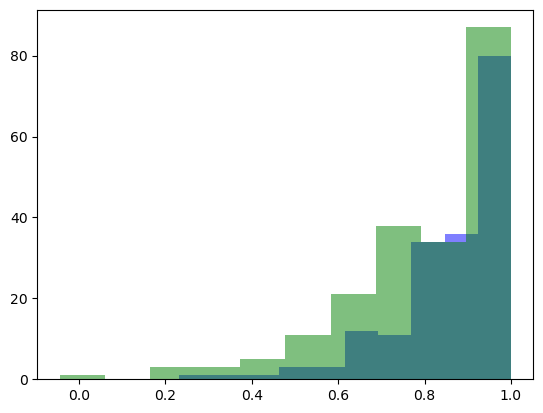

In [61]:
plt.figure()
plt.hist(overall_performance["db_rel_silhouette"], color = 'blue', alpha = .5)
plt.hist(overall_performance["baseline_rel_silhouette"], color = 'green', alpha = .5)
plt.show()

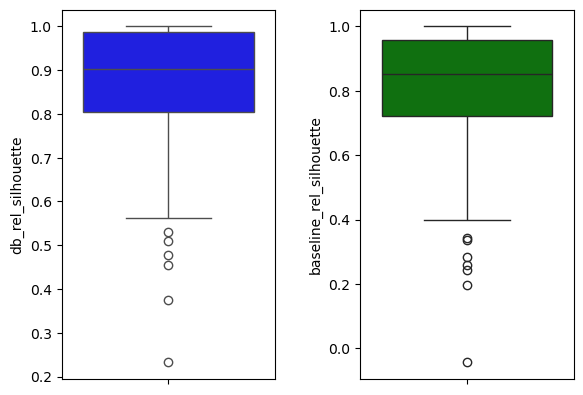

In [62]:
plt.subplots(1, 2)
plt.subplots_adjust(left=0.1, 
                        right=0.9, 
                        wspace=0.4)
plt.subplot(1, 2, 1)
sns.boxplot(overall_performance["db_rel_silhouette"], color = 'blue')
plt.subplot(1, 2, 2)
sns.boxplot(overall_performance["baseline_rel_silhouette"], color = 'green')
plt.show()

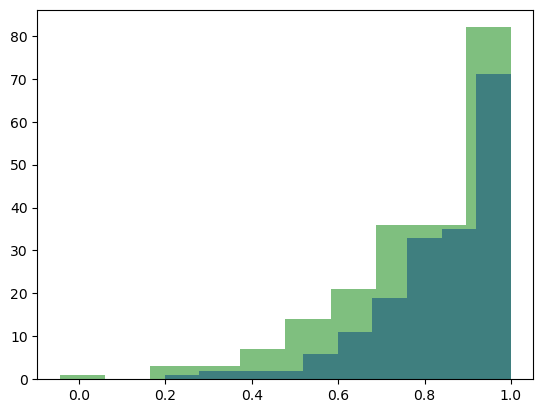

In [63]:
plt.figure()
plt.hist(overall_performance["db_abs_silhouette"], color = 'blue', alpha = .5)
plt.hist(overall_performance["baseline_abs_silhouette"], color = 'green', alpha = .5)
plt.show()

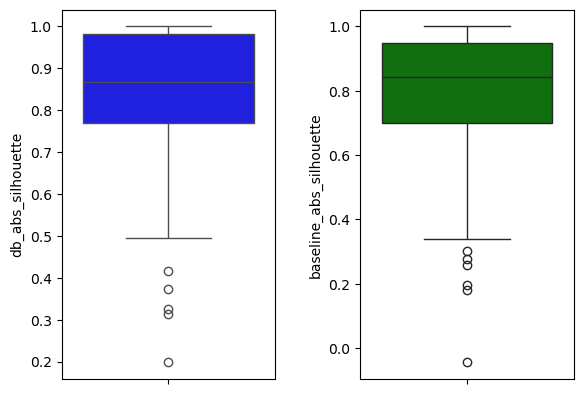

In [64]:
plt.subplots(1, 2)
plt.subplots_adjust(left=0.1, 
                        right=0.9, 
                        wspace=0.4)
plt.subplot(1, 2, 1)
sns.boxplot(overall_performance["db_abs_silhouette"], color = 'blue')
plt.subplot(1, 2, 2)
sns.boxplot(overall_performance["baseline_abs_silhouette"], color = 'green')
plt.show()

In [65]:
# What percent of the scores had dbscan improving on the baseline?
(overall_performance['baseline_rel_silhouette'] < overall_performance['db_rel_silhouette']).sum() / overall_performance.shape[0]

0.5733333333333334

In [66]:
(overall_performance['baseline_abs_silhouette'] < overall_performance['db_abs_silhouette']).sum() / overall_performance.shape[0]

0.5555555555555556

In [67]:
((overall_performance['baseline_rel_silhouette'])*.75 < overall_performance['db_rel_silhouette']).sum() / overall_performance.shape[0]

0.7555555555555555

In [68]:
(overall_performance['db_abs_silhouette'] > 0.9).sum() / overall_performance.shape[0]

0.3511111111111111

In [69]:
overall_performance['db_abs_silhouette'].isna().sum()

43

In [70]:
overall_performance["num_db_clusters"].describe()

count    225.000000
mean      29.084444
std       39.043554
min        0.000000
25%        3.000000
50%       11.000000
75%       36.000000
max      190.000000
Name: num_db_clusters, dtype: float64